In [1]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter  # 导入SummaryWriter

import grid_env
from model import *
from render import *

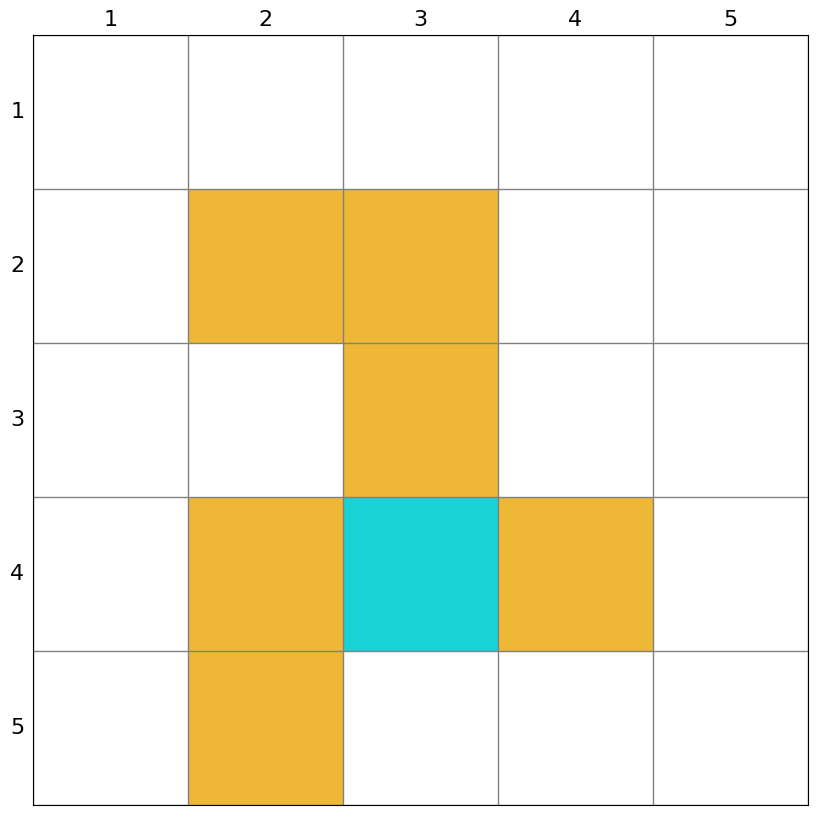

In [2]:
env = grid_env.GridEnv(
    size=5,
    target=[2, 3],
    forbidden=[[1, 1], [2, 1], [2, 2], [1, 3], [3, 3], [1, 4]],
    render_mode=''
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class Critic(nn.Module):
    def __init__(self, num_states=25, num_actions=5):
        super(Critic, self).__init__()
        self.embedding = nn.Embedding(num_states, 8)  # Embedding dimension: 8
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, num_actions)

    def forward(self, state):
        if isinstance(state, int):
            state = torch.tensor([state], dtype=torch.long).to(state.device)
        elif isinstance(state, list):
            state = torch.tensor(state, dtype=torch.long).to(state.device)
        state = self.embedding(state).squeeze(1)  # Shape: [batch_size, embedding_dim]
        state = F.relu(self.fc1(state))
        return self.fc2(state)  # Shape: [batch_size, num_actions]
    
# Define Actor Network
class Actor(nn.Module):
    def __init__(self, num_states=25, num_actions=5):
        super(Actor, self).__init__()
        self.embedding = nn.Embedding(num_states, 8)  # Embedding dimension: 8
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, num_actions)

    def forward(self, state):
        if isinstance(state, int):
            state = torch.tensor([state], dtype=torch.long).to(state.device)
        elif isinstance(state, list):
            state = torch.tensor(state, dtype=torch.long).to(state.device)
        state = self.embedding(state).squeeze(1)  # Shape: [batch_size, embedding_dim]
        state = F.relu(self.fc1(state))
        state = self.fc2(state)
        state = F.softmax(state, dim=-1)  # Action probabilities
        return state  # Shape: [batch_size, num_actions]
    
# Initialize Models
model_actor = Actor().to(device)
model_critic = Critic().to(device)
model_critic_delay = Critic().to(device)
model_critic_delay.load_state_dict(model_critic.state_dict())

<All keys matched successfully>

In [5]:
# Initialize Optimizers (Removed duplicate definitions)
learning_rate_actor = 1e-3  # Adjusted learning rate for actor
learning_rate_critic = 1e-3  # Adjusted learning rate for critic

optimizer_actor = torch.optim.Adam(model_actor.parameters(), lr=learning_rate_actor)
optimizer_critic = torch.optim.Adam(model_critic.parameters(), lr=learning_rate_critic)

In [6]:
# Define Function to Obtain an Episode
def obtain_episode(env, policy_net, start_state):
    action_space_size = env.action_space_size
    # Initialize environment to initial state
    env.reset()
    env.agent_location = env.state2pos(start_state)
    next_state = start_state
    episode = []
    reward_sum = 0
    done = False

    while not done:
        state = next_state
        # Convert state to long tensor for the policy network
        state_tensor = torch.tensor([state], dtype=torch.long).to(device)

        # Forward pass to get action probabilities
        action_probabilities = policy_net(state_tensor).detach()  # Shape: [1, num_actions]

        # Sample an action based on the probabilities
        action = torch.multinomial(action_probabilities, 1).item()

        # Execute the selected action in the environment
        _, reward, done, _, _ = env.step(action)
        reward_sum += reward
        over = 1 if done else 0

        # Get the next state
        next_state = env.pos2state(env.agent_location)

        # Record the step
        episode.append([state, action, reward, next_state, over])

    return episode, reward_sum

In [7]:
# Define Helper Function to Toggle Gradients
def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad = value

In [8]:
# Define Function to Train the Critic
def train_critic(states, actions, rewards, next_states, overs):
    requires_grad(model_actor, False)
    requires_grad(model_critic, True)

    # Convert lists to tensors
    state_tensor = torch.tensor(states, dtype=torch.long).to(device)  # Shape: [batch_size]
    action_tensor = torch.tensor(actions, dtype=torch.long).to(device).unsqueeze(-1)  # Shape: [batch_size, 1]
    reward_tensor = torch.tensor(rewards, dtype=torch.float32).to(device).unsqueeze(-1)  # Shape: [batch_size, 1]
    over_tensor = torch.tensor(overs, dtype=torch.float32).to(device).unsqueeze(-1)      # Shape: [batch_size, 1]
    next_state_tensor = torch.tensor(next_states, dtype=torch.long).to(device)  # Shape: [batch_size]

    # Get current Q-values for the actions taken
    current_q_values = model_critic(state_tensor).gather(dim=1, index=action_tensor)  # Shape: [batch_size, 1]

    # Compute target Q-values using the delayed critic
    with torch.no_grad():
        # For standard Q-Learning, use the max Q-value for the next state
        next_q_values = model_critic_delay(next_state_tensor)  # Shape: [batch_size, num_actions]
        max_next_q_values, _ = next_q_values.max(dim=1, keepdim=True)  # Shape: [batch_size, 1]
        target_q_values = reward_tensor + (1 - over_tensor) * 0.99 * max_next_q_values  # Shape: [batch_size, 1]

    # Compute Temporal Difference (TD) Loss
    loss = F.mse_loss(current_q_values, target_q_values)

    # Backpropagation and Optimization
    optimizer_critic.zero_grad()  # Zero gradients before backward pass
    loss.backward()
    optimizer_critic.step()

    return current_q_values.detach()

In [9]:
#episode , re = obtain_episode(env,model_actor,0)
#states = [step[0] for step in episode]
#actions = [step[1] for step in episode]
#rewards = [step[2] for step in episode]
#next_states = [step[3] for step in episode]
#overs = [step[4] for step in episode]
#qvalue =  train_critic(states,actions,rewards,next_states,overs)
#print(qvalue)

In [10]:
# Define Function to Train the Actor
def train_actor(states, actions, q_values):
    requires_grad(model_actor, True)
    requires_grad(model_critic, False)

    # Convert lists to tensors
    states_tensor = torch.tensor(states, dtype=torch.long).to(device)  # Shape: [batch_size]
    actions_tensor = torch.tensor(actions, dtype=torch.long).to(device).unsqueeze(1)  # Shape: [batch_size, 1]
    q_values_tensor = q_values.to(device)  # Shape: [batch_size, 1]

    # Forward pass to get action probabilities
    prob = model_actor(states_tensor)  # Shape: [batch_size, num_actions]

    # Select the probabilities of the actions taken
    selected_prob = prob.gather(1, actions_tensor)  # Shape: [batch_size, 1]

    # Compute log probabilities and multiply by Q-values
    log_prob = torch.log(torch.clamp(selected_prob, min=1e-8)) * q_values_tensor  # Shape: [batch_size, 1]
    loss = -log_prob.mean()  # Negative to perform gradient ascent

    # Backpropagation and Optimization
    optimizer_actor.zero_grad()  # Zero gradients before backward pass
    loss.backward()
    optimizer_actor.step()

    return loss.item()


In [11]:
#loss = train_actor(states,actions,qvalue)
#print(loss)

In [12]:
# Set Hyperparameters
num_episodes = 1000  # Total number of training episodes
batch_size = 32       # Number of samples per batch (not used in this implementation)
gamma = 0.99          # Discount factor
learning_rate = 1e-3  # Learning rate for both actor and critic

# Initialize TensorBoard Writer
writer = SummaryWriter()

# Initialize Starting State
start_state = 0  # Assuming the initial state is 0

# Define Training Loop
for episode in range(1, num_episodes + 1):
    # Obtain one episode of data using the current policy
    episode_data, total_reward = obtain_episode(env, model_actor, start_state)

    # Extract states, actions, rewards, next_states, and done flags from the episode
    states = [step[0] for step in episode_data]
    actions = [step[1] for step in episode_data]
    rewards = [step[2] for step in episode_data]
    next_states = [step[3] for step in episode_data]
    overs = [step[4] for step in episode_data]

    # Critic network training
    q_value = train_critic(states, actions, rewards, next_states, overs)

    # Actor network training
    loss = train_actor(states, actions, q_value)

    # Update delayed Critic network weights (Soft Update)
    tau = 0.005  # Soft update parameter
    for target_param, param in zip(model_critic_delay.parameters(), model_critic.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    # Print and record training results every 10 episodes
    if episode % 10 == 0:
        print(f"Episode {episode},loss {loss} , Total Reward: {total_reward}")
        writer.add_scalar("Total_Reward", total_reward, episode)

# After training, save the models
torch.save(model_actor.state_dict(), "actor_model.pth")
torch.save(model_critic.state_dict(), "critic_model.pth")
torch.save(model_critic_delay.state_dict(), "critic_delay_model.pth")

# Close TensorBoard Writer
writer.close()

Episode 10,loss -0.013537767343223095 , Total Reward: 0.85
Episode 20,loss 0.14205758273601532 , Total Reward: 0.4999999999999998
Episode 30,loss 0.2321803867816925 , Total Reward: 0.5999999999999999
Episode 40,loss 0.38020768761634827 , Total Reward: 0.85
Episode 50,loss 0.47243791818618774 , Total Reward: -0.5700000000000012
Episode 60,loss 0.4516925513744354 , Total Reward: 0.11999999999999944
Episode 70,loss 0.47972413897514343 , Total Reward: 0.74
Episode 80,loss 0.4436638057231903 , Total Reward: -0.8300000000000014
Episode 90,loss 0.5161299705505371 , Total Reward: -0.18000000000000083
Episode 100,loss 0.5017186403274536 , Total Reward: 0.96
Episode 110,loss 0.4942358136177063 , Total Reward: -0.9100000000000015
Episode 120,loss 0.5320926904678345 , Total Reward: 0.9
Episode 130,loss 0.5031923651695251 , Total Reward: -0.7900000000000014
Episode 140,loss 0.4148864150047302 , Total Reward: 0.47999999999999976
Episode 150,loss 0.47729751467704773 , Total Reward: 0.95
Episode 160,l

In [13]:
# 通过模型获取一个episode
episode, treward = obtain_episode(env, model_actor , 0)
print(episode)

state_space_size = env.size ** 2
action_space_size = env.action_space_size
policy = np.ones((state_space_size, action_space_size))

for state in range(state_space_size):
    # 将状态转换为张量，并确保其形状与模型期望的输入一致
    state_tensor = torch.LongTensor([state]).to(device)
    
    # 模型预测的Q值，假设输出是所有动作的Q值
    q_values = model_actor(state_tensor)
    
    # 获取当前状态下最优的动作
    best_action = q_values.argmax(dim=1).item()  # 获取最优动作索引
    
    # 直接在策略表中更新对应的最优动作的概率（这里可能是设置为1，或者某个概率分布）
    # 注意：policy存储的是每个状态-动作对的值，因此应更新对应位置
    for action in range(action_space_size):
        if action == best_action:
            policy[state][action] = 1.0  # 将最优动作的概率设为1
        else:
            policy[state][action] = 0.0  # 其他动作的概率设为0

# 输出最终的策略
print(policy)

[[0, 1, 0, 1, 0], [1, 2, -0.01, 6, 0], [6, 1, 0, 7, 0], [7, 2, -0.01, 12, 0], [12, 1, 1, 13, 1]]
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


e:\Reinforcement_learning\scripts\render.py:153: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


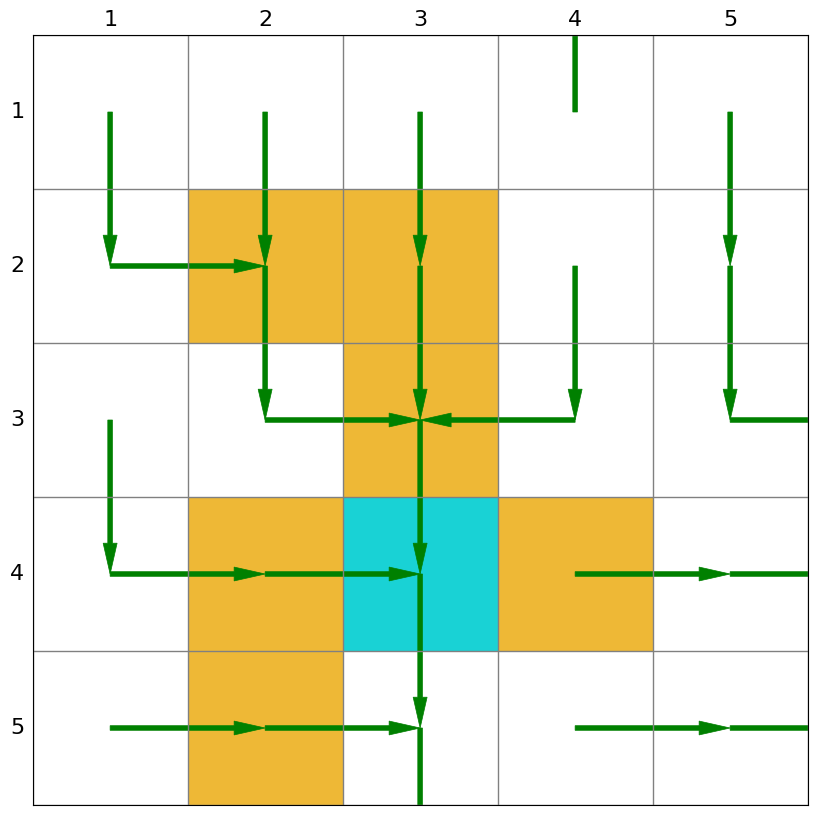

In [14]:
# 定义动作对应的方向
action_to_direction = {
    0: np.array([-1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 0]),
    3: np.array([0, -1]),
    4: np.array([0, 0]),
}
render = Render(target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], size=5)
# 绘制每个状态的最优动作
for state in range(policy.shape[0]):
    # 计算状态在网格中的位置
    row, col = env.state2pos(state)
    
    # 找出当前状态下的最优动作
    best_action = np.argmax(policy[state])
    
    # 根据最优动作绘制箭头
    render.draw_action(pos=[row, col], toward=action_to_direction[best_action])

# 显示结果
render.show_frame()